In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats
import statsmodels.api as sm
import tqdm


In [2]:
predictive_processing_dataset = pd.read_excel("All_Features_dataset.xlsx")
scales = pd.read_excel("filled_scales_BEBRASK_RETOS.xlsx")


In [3]:
scales.drop(["SUBJECT_CODE","Age"],axis=1,inplace=True)

common_values = scales['EPRIME_CODE'].unique()
predictive_processing_dataset = predictive_processing_dataset[predictive_processing_dataset['Subject'].isin(common_values)]


In [27]:
metrics_columns = scales.drop("EPRIME_CODE",axis=1).columns.values
predictive_processing_columns = predictive_processing_dataset.drop("Subject",axis=1).columns.values

In [5]:
feature_scales = pd.merge(left = predictive_processing_dataset,right=scales, left_on="Subject",right_on="EPRIME_CODE").drop(["EPRIME_CODE","Subject"],axis=1)

In [6]:
values = list(range(5, 96, 5))

In [7]:

dataframes = {}
all_dictionary = {}
for value in values:
    
# Assuming feature_scales is your DataFrame with features as columns and metrics as rows
    dictionary_distribution = {}

    for metric in metrics_columns:
        dictionary_distribution[metric] = {}
        
        
        for feature in predictive_processing_columns:
            percentile = np.percentile(feature_scales[feature],value)
            if value < 50:
                above_values = feature_scales[feature_scales[feature] > percentile][metric]  
                below_values = feature_scales[feature_scales[feature] <= percentile][metric]  
            else:
                above_values = feature_scales[feature_scales[feature] >= percentile][metric]  
                below_values = feature_scales[feature_scales[feature] < percentile][metric]  

            u_stat, p_value = stats.mannwhitneyu(above_values, below_values, alternative='two-sided')    
            # Calculate means
            high_mean = np.mean(above_values)
            low_mean = np.mean(below_values)
    
            dictionary_distribution[metric][feature] = {'high_mean': high_mean, 'size_high': len(above_values),
                                                       'low_mean': low_mean, 'size_low': len(below_values),
                                                       'p_value': p_value}

    all_dictionary[value] = dictionary_distribution
    df = pd.DataFrame.from_dict({(metric, feature): values
                                 for metric, features in dictionary_distribution.items()
                                 for feature, values in features.items()}, orient='index')

    # Add this DataFrame to the main dictionary of DataFrames
    dataframes[value] = df

Percentiles where each metric has more relevant features associated with

In [8]:
# Initialize a dictionary to store the top three significant counts per metric
top_significant_counts_per_metric = {metric: [] for metric in metrics_columns}

# Iterate through each metric to determine the top three percentiles with the most significant features
for metric in metrics_columns:
    # Create a list to hold the counts for each percentile for this metric
    metric_counts = []

    for percentile, df in dataframes.items():
        # Filter only rows corresponding to the current metric
        p_values = df.xs(metric, level=0)['p_value']

        # Count the number of features with p-values below 0.05
        significant_count = (p_values < 0.05).sum()

        # Add the count to the list
        metric_counts.append((percentile, significant_count))

    # Sort the list of counts in descending order by count
    metric_counts.sort(key=lambda x: x[1], reverse=True)

    # Keep only the top three counts
    top_significant_counts_per_metric[metric] = metric_counts[:3]

# Display the results
for metric, top_counts in top_significant_counts_per_metric.items():
    print(f"\nMetric: {metric}")
    for rank, (percentile, count) in enumerate(top_counts, 1):
        print(f"  {rank}- Highest: Percentile {percentile} with {count} features having significant p-values")




Metric: PA
  1- Highest: Percentile 45 with 17 features having significant p-values
  2- Highest: Percentile 70 with 15 features having significant p-values
  3- Highest: Percentile 75 with 15 features having significant p-values

Metric: NA.
  1- Highest: Percentile 20 with 5 features having significant p-values
  2- Highest: Percentile 80 with 5 features having significant p-values
  3- Highest: Percentile 30 with 4 features having significant p-values

Metric: ERQ_CR
  1- Highest: Percentile 35 with 12 features having significant p-values
  2- Highest: Percentile 55 with 10 features having significant p-values
  3- Highest: Percentile 30 with 9 features having significant p-values

Metric: ERQ_ES
  1- Highest: Percentile 10 with 5 features having significant p-values
  2- Highest: Percentile 15 with 5 features having significant p-values
  3- Highest: Percentile 75 with 5 features having significant p-values

Metric: UPPSP_NU
  1- Highest: Percentile 95 with 4 features having signi

Relevancy of each feature across all percentiles

In [9]:
# Initialize a dictionary to store counts of significant p-values per feature across all percentiles
significant_counts_aggregate = {feature: [] for feature in predictive_processing_columns}

# Iterate through each percentile and count the significant p-values per feature
for percentile in values:
    df = dataframes[percentile]
    
    # Group by feature only (ignoring the metric)
    significant_count = df['p_value'].groupby(level=1).apply(lambda x: (x < 0.05).sum())
    
    # Append the count for each feature to its corresponding list
    for feature, count in significant_count.items():
        significant_counts_aggregate[feature].append((percentile, count))

# Print the results per feature
for feature, counts in significant_counts_aggregate.items():
    print(f"\nFeature: {feature}")
    for percentile, count in counts:
        print(f"  Percentile {percentile}: {count} significant p-values")



Feature: Mean_Rating0
  Percentile 5: 1 significant p-values
  Percentile 10: 1 significant p-values
  Percentile 15: 1 significant p-values
  Percentile 20: 3 significant p-values
  Percentile 25: 1 significant p-values
  Percentile 30: 3 significant p-values
  Percentile 35: 0 significant p-values
  Percentile 40: 2 significant p-values
  Percentile 45: 3 significant p-values
  Percentile 50: 3 significant p-values
  Percentile 55: 3 significant p-values
  Percentile 60: 1 significant p-values
  Percentile 65: 1 significant p-values
  Percentile 70: 1 significant p-values
  Percentile 75: 1 significant p-values
  Percentile 80: 1 significant p-values
  Percentile 85: 0 significant p-values
  Percentile 90: 0 significant p-values
  Percentile 95: 0 significant p-values

Feature: Mean_Rating0_Match
  Percentile 5: 1 significant p-values
  Percentile 10: 0 significant p-values
  Percentile 15: 2 significant p-values
  Percentile 20: 5 significant p-values
  Percentile 25: 1 significant

Percentiles for with each feature is most relevant

In [10]:
# Initialize a dictionary to store the top three counts of significant p-values per feature
top_significant_counts_per_feature = {feature: [] for feature in predictive_processing_columns}

# Iterate through each percentile and count the significant p-values per feature
for percentile in values:
    df = dataframes[percentile]

    # Group by feature only (ignoring the metric)
    significant_count = df['p_value'].groupby(level=1).apply(lambda x: (x < 0.05).sum())

    # Append the count for each feature to its list
    for feature, count in significant_count.items():
        top_significant_counts_per_feature[feature].append((percentile, count))

# For each feature, sort the counts and keep only the top three
for feature, counts in top_significant_counts_per_feature.items():
    # Sort by the count (second element of the tuple) in descending order
    counts.sort(key=lambda x: x[1], reverse=True)
    # Keep only the top three
    top_significant_counts_per_feature[feature] = counts[:3]

# Print the results showing the top three counts for each feature
for feature, top_counts in top_significant_counts_per_feature.items():
    print(f"\nFeature: {feature}")
    for rank, (percentile, count) in enumerate(top_counts, 1):
        print(f"  {rank}- Highest: Percentile {percentile} with {count} significant p-values")



Feature: Mean_Rating0
  1- Highest: Percentile 20 with 3 significant p-values
  2- Highest: Percentile 30 with 3 significant p-values
  3- Highest: Percentile 45 with 3 significant p-values

Feature: Mean_Rating0_Match
  1- Highest: Percentile 20 with 5 significant p-values
  2- Highest: Percentile 45 with 4 significant p-values
  3- Highest: Percentile 50 with 4 significant p-values

Feature: Mean_Rating0_No_Match
  1- Highest: Percentile 10 with 3 significant p-values
  2- Highest: Percentile 15 with 3 significant p-values
  3- Highest: Percentile 20 with 3 significant p-values

Feature: Mean_Rating0_Match_Happy
  1- Highest: Percentile 45 with 4 significant p-values
  2- Highest: Percentile 55 with 4 significant p-values
  3- Highest: Percentile 60 with 4 significant p-values

Feature: Mean_Rating0_No_Match_Happy
  1- Highest: Percentile 65 with 5 significant p-values
  2- Highest: Percentile 70 with 5 significant p-values
  3- Highest: Percentile 75 with 5 significant p-values

Fe

Most relevant percentiles

In [11]:
# Initialize a list to store the total count of significant p-values for each percentile
total_significant_counts_per_percentile = []

# Iterate through each percentile and count the significant p-values
for percentile in values:
    df = dataframes[percentile]
    
    # Count the number of significant p-values across all features and metrics
    total_significant_count = (df['p_value'] < 0.05).sum()
    
    # Store the total count with its corresponding percentile
    total_significant_counts_per_percentile.append((percentile, total_significant_count))

# Sort the percentiles by the total count of significant p-values in descending order
sorted_significant_counts = sorted(total_significant_counts_per_percentile, key=lambda x: x[1], reverse=True)

# Print the sorted list
print("\nOrdered list of percentiles by significant p-values count (descending):")
for rank, (percentile, count) in enumerate(sorted_significant_counts, 1):
    print(f"{rank}. Percentile {percentile}: {count} significant p-values")




Ordered list of percentiles by significant p-values count (descending):
1. Percentile 90: 132 significant p-values
2. Percentile 45: 124 significant p-values
3. Percentile 80: 120 significant p-values
4. Percentile 95: 120 significant p-values
5. Percentile 30: 118 significant p-values
6. Percentile 40: 115 significant p-values
7. Percentile 35: 112 significant p-values
8. Percentile 75: 111 significant p-values
9. Percentile 85: 109 significant p-values
10. Percentile 50: 108 significant p-values
11. Percentile 60: 107 significant p-values
12. Percentile 55: 106 significant p-values
13. Percentile 70: 106 significant p-values
14. Percentile 65: 101 significant p-values
15. Percentile 25: 97 significant p-values
16. Percentile 20: 91 significant p-values
17. Percentile 15: 85 significant p-values
18. Percentile 10: 65 significant p-values
19. Percentile 5: 60 significant p-values


Most relevant features for each metric

In [12]:
from collections import defaultdict

# Initialize a dictionary to store feature counts and percentiles for each metric
feature_counts_and_percentiles_per_metric = {
    metric: defaultdict(lambda: {"count": 0, "percentiles": []}) for metric in metrics_columns
}

# Iterate through each percentile DataFrame to count significant features per metric
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Increment the count and record the percentile for features where the p-value is below 0.05
        for feature, row in metric_data.iterrows():
            if row['p_value'] < 0.05:
                feature_info = feature_counts_and_percentiles_per_metric[metric][feature]
                feature_info["count"] += 1
                feature_info["percentiles"].append(percentile)

# Determine the top 5 features for each metric
top_features_per_metric = {}

for metric, feature_data in feature_counts_and_percentiles_per_metric.items():
    # Sort features by their count in descending order and get the top 5
    sorted_features = sorted(feature_data.items(), key=lambda x: x[1]["count"], reverse=True)[:5]
    top_features_per_metric[metric] = sorted_features

# Print the results
for metric, top_features in top_features_per_metric.items():
    print(f"\nTop 5 features for metric {metric}:")
    for rank, (feature, data) in enumerate(top_features, 1):
        percentiles_str = ", ".join(map(str, sorted(data["percentiles"])))
        print(f"{rank}. Feature {feature}: {data['count']} significant appearances (percentiles: {percentiles_str})")



Top 5 features for metric PA:
1. Feature Mean_Rating0: 14 significant appearances (percentiles: 5, 10, 15, 20, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80)
2. Feature Final_Value_No_Match_Sad: 14 significant appearances (percentiles: 5, 10, 15, 20, 25, 35, 40, 45, 50, 65, 70, 75, 85, 90)
3. Feature Mean_Rating0_Match_Sad: 13 significant appearances (percentiles: 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 75, 80, 85)
4. Feature Mean_Rating0_No_Match_Negative: 12 significant appearances (percentiles: 10, 15, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75)
5. Feature Mean_Rating0_Match: 11 significant appearances (percentiles: 15, 20, 40, 45, 50, 55, 60, 65, 70, 75, 80)

Top 5 features for metric NA.:
1. Feature Intercept_No_Match_Happy: 12 significant appearances (percentiles: 15, 20, 25, 30, 35, 40, 45, 60, 65, 70, 75, 80)
2. Feature Intercept_Match_Fear: 7 significant appearances (percentiles: 15, 20, 25, 30, 35, 45, 50)
3. Feature Trend_No_Match_Happy: 7 significant appearances (percentiles: 20, 25,

### Negative Features

In [13]:

# List of specific features to examine
specific_features = ["Mean_Rating0_Match_Negative","Mean_Rating0_No_Match_Negative","Dif_Negative",
    "Final_Value_Match_Negative", "Final_Value_No_Match_Negative",
    "Intercept_Match_Negative", "Intercept_No_Match_Negative",
    "Trend_No_Match_Negative", "Trend_Match_Negative",
    "Cor_Pred_Like_Match_Negative", "Cor_Pred_Like_No_Match_Negative",
]

# Initialize a dictionary to store metrics, percentiles, and p-values for each feature
features_summary = {feature: defaultdict(lambda: defaultdict(list)) for feature in specific_features}

# Iterate through each percentile DataFrame to collect data for specified features
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features and if p-value is below 0.05, record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append percentile and p-value under the corresponding metric for this feature
                features_summary[feature][metric]['percentiles'].append(percentile)
                features_summary[feature][metric]['p_values'].append(row['p_value'])

# Display the results for each specific feature
for feature, metrics in features_summary.items():
    print(f"\nFeature: {feature}")
    if all(not details for details in metrics.values()):
        print("  No significant appearances across any metrics or percentiles.")
    else:
        for metric, details in metrics.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                p_values = ", ".join(f"{p:.4f}" for p in details['p_values'])
                print(f"  Metric: {metric}")
                print(f"    Significant at percentiles: {percentiles} with p-values: {p_values}")




Feature: Mean_Rating0_Match_Negative
  Metric: ERQ_CR
    Significant at percentiles: 10, 30, 35, 45, 50, 55 with p-values: 0.0414, 0.0171, 0.0261, 0.0318, 0.0318, 0.0345
  Metric: UPPSP_PSV
    Significant at percentiles: 25, 30, 35, 40, 45, 50, 55, 80 with p-values: 0.0167, 0.0106, 0.0024, 0.0055, 0.0094, 0.0094, 0.0483, 0.0471
  Metric: PA
    Significant at percentiles: 35, 40, 45, 50, 55, 60, 65, 70, 75, 80 with p-values: 0.0202, 0.0256, 0.0236, 0.0236, 0.0095, 0.0056, 0.0056, 0.0054, 0.0341, 0.0229
  Metric: TEPS_CF
    Significant at percentiles: 35, 40, 55, 60, 65 with p-values: 0.0258, 0.0309, 0.0337, 0.0170, 0.0170
  Metric: RRQ_Ref
    Significant at percentiles: 85 with p-values: 0.0466
  Metric: MSSB_DES
    Significant at percentiles: 90 with p-values: 0.0387

Feature: Mean_Rating0_No_Match_Negative
  Metric: PA
    Significant at percentiles: 10, 15, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75 with p-values: 0.0493, 0.0493, 0.0036, 0.0036, 0.0220, 0.0409, 0.0220, 0.0409, 0.0

In [14]:

# Initialize a dictionary to store features, percentiles, and p-values for each metric
metrics_summary = {metric: defaultdict(lambda: defaultdict(list)) for metric in metrics_columns}

# Iterate through each percentile DataFrame to collect data for specified metrics
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features if p-value is below 0.05 and record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append feature, percentile, and p-value under the corresponding metric
                metrics_summary[metric][feature]['percentiles'].append(percentile)
                metrics_summary[metric][feature]['p_values'].append(row['p_value'])

# Display the results for each metric
for metric, features in metrics_summary.items():
    print(f"\nMetric: {metric}")
    if all(not details for details in features.values()):
        print("  No significant features across any percentiles.")
    else:
        for feature, details in features.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                p_values = ", ".join(f"{p:.4f}" for p in details['p_values'])
                print(f"  Feature: {feature}")
                print(f"    Significant at percentiles: {percentiles} with p-values: {p_values}")



Metric: PA
  Feature: Intercept_No_Match_Negative
    Significant at percentiles: 5 with p-values: 0.0430
  Feature: Mean_Rating0_No_Match_Negative
    Significant at percentiles: 10, 15, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75 with p-values: 0.0493, 0.0493, 0.0036, 0.0036, 0.0220, 0.0409, 0.0220, 0.0409, 0.0409, 0.0118, 0.0118, 0.0354
  Feature: Cor_Pred_Like_Match_Negative
    Significant at percentiles: 15 with p-values: 0.0106
  Feature: Mean_Rating0_Match_Negative
    Significant at percentiles: 35, 40, 45, 50, 55, 60, 65, 70, 75, 80 with p-values: 0.0202, 0.0256, 0.0236, 0.0236, 0.0095, 0.0056, 0.0056, 0.0054, 0.0341, 0.0229
  Feature: Final_Value_No_Match_Negative
    Significant at percentiles: 35, 40, 45, 50, 55, 60, 65, 70, 75, 90 with p-values: 0.0157, 0.0177, 0.0174, 0.0085, 0.0161, 0.0015, 0.0039, 0.0009, 0.0025, 0.0193
  Feature: Final_Value_Match_Negative
    Significant at percentiles: 40, 45, 50, 55, 60, 70 with p-values: 0.0303, 0.0047, 0.0009, 0.0115, 0.0327, 0.0283


In [15]:

# Initialize a dictionary to store features, percentiles, and high/low means for each metric
metrics_summary = {metric: defaultdict(lambda: {
    'percentiles': [],
    'high_means': [],
    'low_means': []
}) for metric in metrics_columns}

# Iterate through each percentile DataFrame to collect data for specified metrics
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features and if p-value is below 0.05, record the high and low means
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append feature details under the corresponding metric
                feature_data = metrics_summary[metric]
                if feature not in feature_data:
                    feature_data[feature] = {
                        'percentiles': [],
                        'high_means': [],
                        'low_means': []
                    }
                feature_data[feature]['percentiles'].append(percentile)
                feature_data[feature]['high_means'].append(row['high_mean'])
                feature_data[feature]['low_means'].append(row['low_mean'])

# Display the results for each metric
for metric, features in metrics_summary.items():
    print(f"\nMetric: {metric}")
    if features:
        for feature, details in features.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                high_means = ", ".join(f"{hm:.2f}" for hm in details['high_means'])
                low_means = ", ".join(f"{lm:.2f}" for lm in details['low_means'])
                print(f"  Feature: {feature}")
                print(f"    Significant at percentiles: {percentiles}")
                print(f"    High Means: {high_means}")
                print(f"    Low Means: {low_means}")
    else:
        print("  No significant features.")



Metric: PA
  Feature: Intercept_No_Match_Negative
    Significant at percentiles: 5
    High Means: 33.00
    Low Means: 37.50
  Feature: Mean_Rating0_No_Match_Negative
    Significant at percentiles: 10, 15, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75
    High Means: 33.80, 33.80, 34.46, 34.46, 34.36, 34.51, 34.36, 34.51, 34.51, 35.05, 35.05, 35.09
    Low Means: 30.70, 30.70, 31.09, 31.09, 31.75, 32.15, 31.75, 32.15, 32.15, 32.18, 32.18, 32.47
  Feature: Cor_Pred_Like_Match_Negative
    Significant at percentiles: 15
    High Means: 32.69
    Low Means: 36.26
  Feature: Mean_Rating0_Match_Negative
    Significant at percentiles: 35, 40, 45, 50, 55, 60, 65, 70, 75, 80
    High Means: 34.22, 34.29, 34.36, 34.36, 34.65, 34.90, 34.90, 35.24, 35.02, 35.41
    Low Means: 31.67, 31.84, 32.04, 32.04, 31.96, 32.02, 32.02, 32.20, 32.56, 32.65
  Feature: Final_Value_No_Match_Negative
    Significant at percentiles: 35, 40, 45, 50, 55, 60, 65, 70, 75, 90
    High Means: 34.14, 34.37, 34.41, 34.61, 3

### Positive Features (Happy)

In [16]:

# List of specific features to examine
specific_features = ["Mean_Rating0_Match_Happy","Mean_Rating0_No_Match_Happy","Dif_Happy",
    "Final_Value_Match_Happy", "Final_Value_No_Match_Happy",
    "Intercept_Match_Happy", "Intercept_No_Match_Happy",
    "Trend_No_Match_Happy", "Trend_Match_Happy",
    "Cor_Pred_Like_Match_Happy", "Cor_Pred_Like_No_Match_Happy"
]

# Initialize a dictionary to store metrics, percentiles, and p-values for each feature
features_summary = {feature: defaultdict(lambda: defaultdict(list)) for feature in specific_features}

# Iterate through each percentile DataFrame to collect data for specified features
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features and if p-value is below 0.05, record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append percentile and p-value under the corresponding metric for this feature
                features_summary[feature][metric]['percentiles'].append(percentile)
                features_summary[feature][metric]['p_values'].append(row['p_value'])

# Display the results for each specific feature
for feature, metrics in features_summary.items():
    print(f"\nFeature: {feature}")
    if all(not details for details in metrics.values()):
        print("  No significant appearances across any metrics or percentiles.")
    else:
        for metric, details in metrics.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                p_values = ", ".join(f"{p:.4f}" for p in details['p_values'])
                print(f"  Metric: {metric}")
                print(f"    Significant at percentiles: {percentiles} with p-values: {p_values}")




Feature: Mean_Rating0_Match_Happy
  Metric: ASI_C
    Significant at percentiles: 5, 10, 15, 20, 25 with p-values: 0.0141, 0.0255, 0.0074, 0.0074, 0.0203
  Metric: PA
    Significant at percentiles: 10, 45, 55, 60, 65, 95 with p-values: 0.0329, 0.0098, 0.0098, 0.0098, 0.0098, 0.0090
  Metric: ASI_P
    Significant at percentiles: 10, 15, 20, 25, 45, 55, 60, 65 with p-values: 0.0245, 0.0107, 0.0107, 0.0409, 0.0298, 0.0298, 0.0298, 0.0298
  Metric: LOT_R
    Significant at percentiles: 15, 20, 45, 55, 60, 65 with p-values: 0.0496, 0.0496, 0.0212, 0.0212, 0.0212, 0.0212
  Metric: UPPSP_PMD
    Significant at percentiles: 30, 35, 40, 50, 70, 75, 80 with p-values: 0.0328, 0.0328, 0.0328, 0.0328, 0.0159, 0.0159, 0.0159
  Metric: BAS_RR
    Significant at percentiles: 30, 35, 40, 50, 85, 90 with p-values: 0.0355, 0.0355, 0.0355, 0.0355, 0.0220, 0.0220
  Metric: TEPS_CF
    Significant at percentiles: 30, 35, 40, 45, 50, 55, 60, 65 with p-values: 0.0380, 0.0380, 0.0380, 0.0073, 0.0380, 0.0073

In [17]:

# Initialize a dictionary to store features, percentiles, and p-values for each metric
metrics_summary = {metric: defaultdict(lambda: defaultdict(list)) for metric in metrics_columns}

# Iterate through each percentile DataFrame to collect data for specified metrics
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features if p-value is below 0.05 and record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append feature, percentile, and p-value under the corresponding metric
                metrics_summary[metric][feature]['percentiles'].append(percentile)
                metrics_summary[metric][feature]['p_values'].append(row['p_value'])

# Display the results for each metric
for metric, features in metrics_summary.items():
    print(f"\nMetric: {metric}")
    if all(not details for details in features.values()):
        print("  No significant features across any percentiles.")
    else:
        for feature, details in features.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                p_values = ", ".join(f"{p:.4f}" for p in details['p_values'])
                print(f"  Feature: {feature}")
                print(f"    Significant at percentiles: {percentiles} with p-values: {p_values}")



Metric: PA
  Feature: Cor_Pred_Like_No_Match_Happy
    Significant at percentiles: 5, 10, 50, 55, 60 with p-values: 0.0271, 0.0210, 0.0094, 0.0094, 0.0094
  Feature: Mean_Rating0_Match_Happy
    Significant at percentiles: 10, 45, 55, 60, 65, 95 with p-values: 0.0329, 0.0098, 0.0098, 0.0098, 0.0098, 0.0090
  Feature: Intercept_No_Match_Happy
    Significant at percentiles: 15, 20, 25, 30, 35, 40, 45, 60 with p-values: 0.0462, 0.0462, 0.0462, 0.0462, 0.0462, 0.0462, 0.0462, 0.0462
  Feature: Dif_Happy
    Significant at percentiles: 20, 65, 70, 75, 80, 85, 90, 95 with p-values: 0.0305, 0.0157, 0.0409, 0.0027, 0.0007, 0.0063, 0.0028, 0.0053
  Feature: Intercept_Match_Happy
    Significant at percentiles: 25, 30, 75, 80, 95 with p-values: 0.0085, 0.0295, 0.0092, 0.0063, 0.0139
  Feature: Trend_Match_Happy
    Significant at percentiles: 30, 40, 45 with p-values: 0.0311, 0.0222, 0.0297
  Feature: Cor_Pred_Like_Match_Happy
    Significant at percentiles: 85, 90, 95 with p-values: 0.0423, 0

In [18]:

# Initialize a dictionary to store features, percentiles, and high/low means for each metric
metrics_summary = {metric: defaultdict(lambda: {
    'percentiles': [],
    'high_means': [],
    'low_means': []
}) for metric in metrics_columns}

# Iterate through each percentile DataFrame to collect data for specified metrics
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features and if p-value is below 0.05, record the high and low means
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append feature details under the corresponding metric
                feature_data = metrics_summary[metric]
                if feature not in feature_data:
                    feature_data[feature] = {
                        'percentiles': [],
                        'high_means': [],
                        'low_means': []
                    }
                feature_data[feature]['percentiles'].append(percentile)
                feature_data[feature]['high_means'].append(row['high_mean'])
                feature_data[feature]['low_means'].append(row['low_mean'])

# Display the results for each metric
for metric, features in metrics_summary.items():
    print(f"\nMetric: {metric}")
    if features:
        for feature, details in features.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                high_means = ", ".join(f"{hm:.2f}" for hm in details['high_means'])
                low_means = ", ".join(f"{lm:.2f}" for lm in details['low_means'])
                print(f"  Feature: {feature}")
                print(f"    Significant at percentiles: {percentiles}")
                print(f"    High Means: {high_means}")
                print(f"    Low Means: {low_means}")
    else:
        print("  No significant features.")



Metric: PA
  Feature: Cor_Pred_Like_No_Match_Happy
    Significant at percentiles: 5, 10, 50, 55, 60
    High Means: 33.54, 33.63, 33.69, 33.69, 33.69
    Low Means: 29.10, 29.80, 29.50, 29.50, 29.50
  Feature: Mean_Rating0_Match_Happy
    Significant at percentiles: 10, 45, 55, 60, 65, 95
    High Means: 33.62, 34.68, 34.68, 34.68, 34.68, 37.75
    Low Means: 30.68, 32.04, 32.04, 32.04, 32.04, 32.85
  Feature: Intercept_No_Match_Happy
    Significant at percentiles: 15, 20, 25, 30, 35, 40, 45, 60
    High Means: 32.02, 32.02, 32.02, 32.02, 32.02, 32.02, 32.02, 32.02
    Low Means: 34.07, 34.07, 34.07, 34.07, 34.07, 34.07, 34.07, 34.07
  Feature: Dif_Happy
    Significant at percentiles: 20, 65, 70, 75, 80, 85, 90, 95
    High Means: 33.74, 34.67, 34.49, 35.63, 36.26, 36.38, 37.05, 38.25
    Low Means: 31.27, 32.43, 32.63, 32.33, 32.32, 32.64, 32.65, 32.80
  Feature: Intercept_Match_Happy
    Significant at percentiles: 25, 30, 75, 80, 95
    High Means: 34.01, 33.94, 35.66, 36.23, 38

#### Joined Positive and Negative

In [19]:
predictive_processing_columns

array(['Mean_Rating0', 'Mean_Rating0_Match', 'Mean_Rating0_No_Match',
       'Mean_Rating0_Match_Happy', 'Mean_Rating0_No_Match_Happy',
       'Mean_Rating0_Match_Sad', 'Mean_Rating0_No_Match_Sad',
       'Mean_Rating0_Match_Fear', 'Mean_Rating0_No_Match_Fear',
       'Mean_Rating0_Match_Negative', 'Mean_Rating0_No_Match_Negative',
       'Dif_Match', 'Dif_Happy', 'Dif_Sad', 'Dif_Fear', 'Dif_Negative',
       'Cor_Pred_Like', 'Cor_Pred_Like_Match', 'Cor_Pred_Like_No_Match',
       'Cor_Pred_Like_Match_Happy', 'Cor_Pred_Like_No_Match_Happy',
       'Cor_Pred_Like_Match_Sad', 'Cor_Pred_Like_No_Match_Sad',
       'Cor_Pred_Like_Match_Fear', 'Cor_Pred_Like_No_Match_Fear',
       'Cor_Pred_Like_Match_Negative', 'Cor_Pred_Like_No_Match_Negative',
       'Trend_Match', 'Trend_No_Match', 'Intercept_Match',
       'Intercept_No_Match', 'Trend_Match_Happy', 'Trend_No_Match_Happy',
       'Intercept_Match_Happy', 'Intercept_No_Match_Happy',
       'Trend_Match_Sad', 'Trend_No_Match_Sad', 'Interce

In [20]:

# List of specific features to examine
specific_features = ["Mean_Rating0","Mean_Rating0_Match","Mean_Rating0_No_Match","Dif_Match","Cor_Pred_Like","Cor_Pred_Like_Match","Cor_Pred_Like_No_Match","Mean_Rating0_Match_Negative","Mean_Rating0_No_Match_Negative","Dif_Negative","Trend_Match","Trend_No_Match",
    "Trend_No_Match_Negative", "Trend_Match_Negative",
    "Cor_Pred_Like_Match_Negative", "Cor_Pred_Like_No_Match_Negative","Mean_Rating0_Match_Happy","Mean_Rating0_No_Match_Happy","Dif_Happy",
    "Trend_No_Match_Happy", "Trend_Match_Happy",
    "Cor_Pred_Like_Match_Happy", "Cor_Pred_Like_No_Match_Happy"
]

# Initialize a dictionary to store metrics, percentiles, and p-values for each feature
features_summary = {feature: defaultdict(lambda: defaultdict(list)) for feature in specific_features}

# Iterate through each percentile DataFrame to collect data for specified features
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features and if p-value is below 0.05, record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append percentile and p-value under the corresponding metric for this feature
                features_summary[feature][metric]['high_means'].append(row['high_mean'])
                features_summary[feature][metric]['low_means'].append(row['low_mean'])
                features_summary[feature][metric]['percentiles'].append(percentile)
                features_summary[feature][metric]['p_values'].append(row['p_value'])

# Display the results for each specific feature
for feature, metrics in features_summary.items():
    print(f"\nFeature: {feature}")
    if all(not details for details in metrics.values()):
        print("  No significant appearances across any metrics or percentiles.")
    else:
        for metric, details in metrics.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                high_means = ", ".join(f"{hm:.2f}" for hm in details['high_means'])
                low_means = ", ".join(f"{lm:.2f}" for lm in details['low_means'])
                print(f"  Metric: {metric}")
                print(f"    Significant at percentiles: {percentiles}")
                print(f"    High Means: {high_means}")
                print(f"    Low Means: {low_means}")




Feature: Mean_Rating0
  Metric: PA
    Significant at percentiles: 5, 10, 15, 20, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80
    High Means: 33.63, 33.66, 33.88, 33.93, 34.03, 34.21, 34.34, 34.34, 34.86, 35.18, 35.17, 35.16, 35.52, 35.55
    Low Means: 28.36, 29.53, 29.92, 30.72, 31.63, 31.98, 31.90, 31.90, 31.85, 31.93, 32.18, 32.30, 32.35, 32.64
  Metric: UPPSP_PSV
    Significant at percentiles: 20, 25, 30, 40, 45, 50, 55
    High Means: 6.78, 6.73, 6.75, 6.70, 6.70, 6.70, 6.65
    Low Means: 8.03, 7.88, 7.65, 7.49, 7.48, 7.48, 7.39
  Metric: BIS
    Significant at percentiles: 20
    High Means: 21.29
    Low Means: 22.84
  Metric: UPPSP_SS
    Significant at percentiles: 30
    High Means: 11.21
    Low Means: 10.12
  Metric: TEPS_CF
    Significant at percentiles: 45, 50, 55
    High Means: 36.61, 36.61, 37.10
    Low Means: 34.42, 34.42, 34.35

Feature: Mean_Rating0_Match
  Metric: BAS_FS
    Significant at percentiles: 5
    High Means: 12.53
    Low Means: 11.00
  Metric: PA
    

In [21]:

# Initialize a dictionary to store features, percentiles, and p-values for each metric
metrics_summary = {metric: defaultdict(lambda: defaultdict(list)) for metric in metrics_columns}

# Iterate through each percentile DataFrame to collect data for specified metrics
for percentile, df in dataframes.items():
    for metric in metrics_columns:
        # Extract rows corresponding to the current metric
        metric_data = df.xs(metric, level=0)

        # Check for specific features if p-value is below 0.05 and record the data
        for feature, row in metric_data.iterrows():
            if feature in specific_features and row['p_value'] < 0.05:
                # Append feature, percentile, and p-value under the corresponding metric
                metrics_summary[metric][feature]['percentiles'].append(percentile)
                metrics_summary[metric][feature]['p_values'].append(row['p_value'])

# Display the results for each metric
for metric, features in metrics_summary.items():
    print(f"\nMetric: {metric}")
    if all(not details for details in features.values()):
        print("  No significant features across any percentiles.")
    else:
        for feature, details in features.items():
            if details['percentiles']:  # Check if there are significant entries
                percentiles = ", ".join(map(str, sorted(details['percentiles'])))
                p_values = ", ".join(f"{p:.4f}" for p in details['p_values'])
                print(f"  Feature: {feature}")
                print(f"    Significant at percentiles: {percentiles} with p-values: {p_values}")



Metric: PA
  Feature: Mean_Rating0
    Significant at percentiles: 5, 10, 15, 20, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80 with p-values: 0.0154, 0.0264, 0.0082, 0.0227, 0.0358, 0.0361, 0.0185, 0.0185, 0.0036, 0.0020, 0.0055, 0.0082, 0.0048, 0.0196
  Feature: Cor_Pred_Like_No_Match_Happy
    Significant at percentiles: 5, 10, 50, 55, 60 with p-values: 0.0271, 0.0210, 0.0094, 0.0094, 0.0094
  Feature: Mean_Rating0_Match_Happy
    Significant at percentiles: 10, 45, 55, 60, 65, 95 with p-values: 0.0329, 0.0098, 0.0098, 0.0098, 0.0098, 0.0090
  Feature: Mean_Rating0_No_Match_Negative
    Significant at percentiles: 10, 15, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75 with p-values: 0.0493, 0.0493, 0.0036, 0.0036, 0.0220, 0.0409, 0.0220, 0.0409, 0.0409, 0.0118, 0.0118, 0.0354
  Feature: Mean_Rating0_Match
    Significant at percentiles: 15, 20, 40, 45, 50, 55, 60, 65, 70, 75, 80 with p-values: 0.0442, 0.0394, 0.0238, 0.0104, 0.0385, 0.0104, 0.0014, 0.0032, 0.0063, 0.0188, 0.0291
  Feature: Cor_Pr

In [22]:
# Collect all significant features for each metric
metric_features = defaultdict(set)
for metric, features in metrics_summary.items():
    for feature, details in features.items():
        if details['percentiles']:  # Check if the feature has any significant appearances
            metric_features[metric].add(feature)

# Compute intersections and unions for percentage calculation
significant_correlations = []

for i, metric1 in enumerate(metrics_columns):
    for metric2 in metrics_columns[i+1:]:  # Compare each pair once
        common_features = metric_features[metric1].intersection(metric_features[metric2])
        union_features = metric_features[metric1].union(metric_features[metric2])
        if union_features:  # Ensure the union is not empty
            percentage_common = len(common_features) / len(union_features) * 100
            if percentage_common >= 40:  # Filter for more than 50% overlap
                significant_correlations.append((metric1, metric2, percentage_common))

# Print results for significant correlations over 50%
print("Significant Metric Correlations (over 50% common features):")
for metric1, metric2, percentage in significant_correlations:
    print(f"{metric1} and {metric2}: {percentage:.2f}% common features")


Significant Metric Correlations (over 50% common features):
PA and ERQ_CR: 64.71% common features
PA and UPPSP_PSV: 55.56% common features
PA and BIS: 40.00% common features
PA and TEPS_CF: 50.00% common features
PA and RRQ_Ref: 44.44% common features
PA and MSSB_DES: 41.18% common features
ERQ_CR and UPPSP_PSV: 41.18% common features
ERQ_CR and TEPS_CF: 42.86% common features
ERQ_CR and RRQ_Ref: 46.67% common features
ERQ_CR and ASI_P: 46.15% common features
ERQ_CR and ASI_C: 50.00% common features
ERQ_ES and UPPSP_SS: 40.00% common features
ERQ_ES and LOT_R: 40.00% common features
ERQ_ES and RRQ_Ref: 45.45% common features
UPPSP_NU and UPPSP_PSV: 50.00% common features
UPPSP_PU and BAS_RR: 40.00% common features
UPPSP_PU and BAS_D: 50.00% common features
UPPSP_PU and SHS: 50.00% common features
UPPSP_PU and LOT_R: 40.00% common features
UPPSP_PMD and BIS: 42.86% common features
UPPSP_PMD and ASI_S: 40.00% common features
UPPSP_PMD and SPQ: 44.44% common features
UPPSP_PSV and BIS: 41

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Collect all significant features for each metric
metric_features = defaultdict(set)
for metric, features in metrics_summary.items():
    for feature, details in features.items():
        if details['percentiles']:  # Assuming this check is for significance
            metric_features[metric].add(feature)

# Prepare a DataFrame to hold the percentage values
correlation_matrix = pd.DataFrame(index=metrics_columns, columns=metrics_columns, dtype=float)


In [24]:
for metric1 in metrics_columns:
    for metric2 in metrics_columns:
        common_features = metric_features[metric1].intersection(metric_features[metric2])
        union_features = metric_features[metric1].union(metric_features[metric2])
        percentage_common = len(common_features) / len(union_features) * 100 if union_features else 0
        correlation_matrix.at[metric1, metric2] = percentage_common


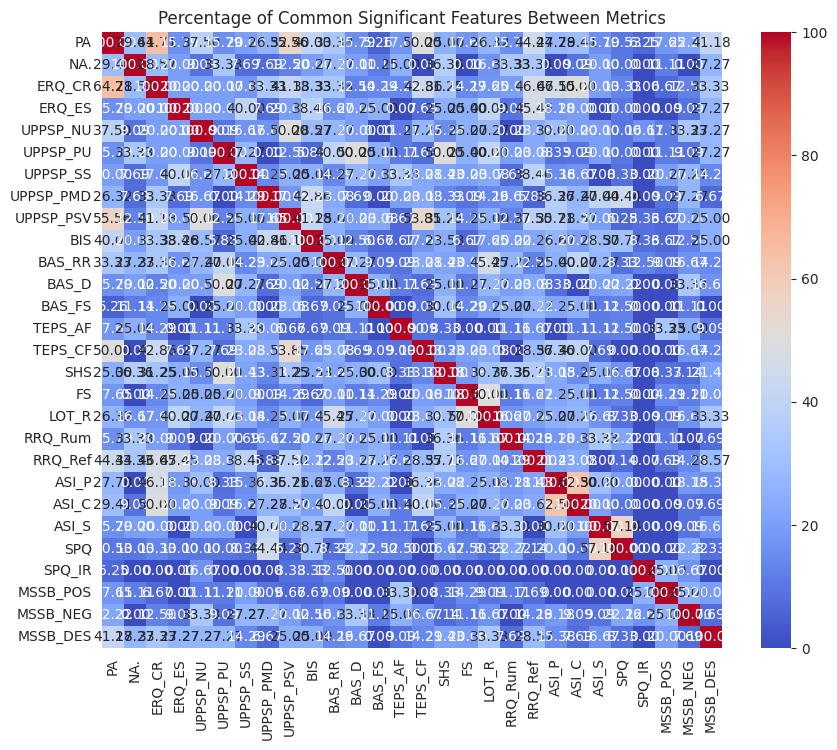

In [25]:
# Using seaborn to plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Percentage of Common Significant Features Between Metrics')
plt.show()



In [26]:
from collections import defaultdict

# Collect all significant features for each metric
metric_features = defaultdict(set)
for metric, features in metrics_summary.items():
    for feature, details in features.items():
        if details['percentiles']:  # Check if the feature has any significant appearances
            metric_features[metric].add(feature)

# Compute intersections and unions for percentage calculation
significant_correlations = []

for i, metric1 in enumerate(metrics_columns):
    for metric2 in metrics_columns[i+1:]:  # Compare each pair once
        common_features = metric_features[metric1].intersection(metric_features[metric2])
        union_features = metric_features[metric1].union(metric_features[metric2])
        if union_features:  # Ensure the union is not empty
            percentage_common = len(common_features) / len(union_features) * 100
            if percentage_common >= 40:  # Filter for more than 50% overlap
                significant_correlations.append((metric1, metric2, percentage_common))

# Print results for significant correlations over 50%
print("Significant Metric Correlations (over 40% common features):")
for metric1, metric2, percentage in significant_correlations:
    print(f"{metric1} and {metric2}: {percentage:.2f}% common features")


Significant Metric Correlations (over 40% common features):
PA and ERQ_CR: 64.71% common features
PA and UPPSP_PSV: 55.56% common features
PA and BIS: 40.00% common features
PA and TEPS_CF: 50.00% common features
PA and RRQ_Ref: 44.44% common features
PA and MSSB_DES: 41.18% common features
ERQ_CR and UPPSP_PSV: 41.18% common features
ERQ_CR and TEPS_CF: 42.86% common features
ERQ_CR and RRQ_Ref: 46.67% common features
ERQ_CR and ASI_P: 46.15% common features
ERQ_CR and ASI_C: 50.00% common features
ERQ_ES and UPPSP_SS: 40.00% common features
ERQ_ES and LOT_R: 40.00% common features
ERQ_ES and RRQ_Ref: 45.45% common features
UPPSP_NU and UPPSP_PSV: 50.00% common features
UPPSP_PU and BAS_RR: 40.00% common features
UPPSP_PU and BAS_D: 50.00% common features
UPPSP_PU and SHS: 50.00% common features
UPPSP_PU and LOT_R: 40.00% common features
UPPSP_PMD and BIS: 42.86% common features
UPPSP_PMD and ASI_S: 40.00% common features
UPPSP_PMD and SPQ: 44.44% common features
UPPSP_PSV and BIS: 41

### Idea of Algorithm

In [44]:
import numpy as np
import pandas as pd
import random

from itertools import product

np.random.seed(42)  # For reproducibility

# Assuming features_summary is a dictionary with keys as feature names
features = list(features_summary.keys())  # List of features
percentiles = list(range(15, 85, 5))  # Percentiles from 5 to 95, inclusive, in steps of 5

# Create all possible combinations of features and percentiles
all_combinations = list(product(features, percentiles))

# Shuffle the combinations to randomize them
random.shuffle(all_combinations)

initializations = [{'feature': combo[0], 'percentile': combo[1]} for combo in all_combinations[:50]]


results = []

for init in initializations:
    feature = init['feature']
    percentile_cutoff = init['percentile']
    significant_counts = 0
    p_values = []

    percentile = np.percentile(feature_scales[feature], percentile_cutoff)
        
    if percentile_cutoff < 50:
        above_values = feature_scales[feature_scales[feature] > percentile] 
        below_values = feature_scales[feature_scales[feature] <= percentile]  
    else:
        above_values = feature_scales[feature_scales[feature] >= percentile]  
        below_values = feature_scales[feature_scales[feature] < percentile]  
    for metric in metrics_columns:
        
        u_stat, p_value = stats.mannwhitneyu(below_values[metric], above_values[metric], alternative='two-sided')
        if p_value < 0.05:
            significant_counts += 1
            p_values.append(p_value)
            
    if p_values:
        mean_p_value = np.mean(p_values)
        results.append({
            'feature': feature,
            'percentile': percentile_cutoff,
            'significant_counts': significant_counts,
            'mean_p_value': mean_p_value
        })

results.sort(key=lambda x: (-x['significant_counts'], x['mean_p_value']))

# Select the top 10
top_20_initializations = results[:20]

# Print top 10 results
for rank, res in enumerate(top_20_initializations, 1):
    print(f"Rank {rank}: Feature = {res['feature']}, Percentile = {res['percentile']}, "
          f"Significant Counts = {res['significant_counts']}, Mean P-Value = {res['mean_p_value']:.4f}")


Rank 1: Feature = Mean_Rating0_No_Match_Happy, Percentile = 65, Significant Counts = 5, Mean P-Value = 0.0254
Rank 2: Feature = Mean_Rating0_No_Match_Happy, Percentile = 55, Significant Counts = 4, Mean P-Value = 0.0142
Rank 3: Feature = Trend_Match_Negative, Percentile = 25, Significant Counts = 4, Mean P-Value = 0.0175
Rank 4: Feature = Trend_Match, Percentile = 45, Significant Counts = 4, Mean P-Value = 0.0275
Rank 5: Feature = Trend_No_Match_Happy, Percentile = 50, Significant Counts = 4, Mean P-Value = 0.0325
Rank 6: Feature = Dif_Happy, Percentile = 40, Significant Counts = 3, Mean P-Value = 0.0118
Rank 7: Feature = Mean_Rating0_No_Match_Negative, Percentile = 30, Significant Counts = 3, Mean P-Value = 0.0153
Rank 8: Feature = Mean_Rating0_No_Match, Percentile = 60, Significant Counts = 3, Mean P-Value = 0.0216
Rank 9: Feature = Mean_Rating0_No_Match, Percentile = 45, Significant Counts = 3, Mean P-Value = 0.0216
Rank 10: Feature = Mean_Rating0_Match_Negative, Percentile = 45, Si

In [58]:
import numpy as np
import pandas as pd
from itertools import product
from scipy import stats
import random

np.random.seed(42)  # For reproducibility

# Assuming top_10_initializations and feature_scales are available from step 1
# Create additional 100 random pairs for each top 10 feature-percentile pair, excluding the initial feature
extended_initializations = []
for top_pair in top_20_initializations:
    top_feature = top_pair['feature']
    top_percentile = top_pair['percentile']

    # Exclude the initial feature from the new selection list
    available_features = [feature for feature in features if feature != top_feature]
    
    # Create combinations excluding the initial feature
    all_combinations = list(product(available_features, np.arange(15, 85, 5)))
    random.shuffle(all_combinations)
    
    # Append new combinations with excluded initial feature
    extended_initializations.extend([{
        'initial_feature': top_feature,
        'initial_percentile': top_percentile,
        'new_feature': combo[0],
        'new_percentile': combo[1]
    } for combo in all_combinations[:50]])

# Evaluate each extended combination
extended_results = []

import numpy as np
import pandas as pd
from itertools import product
from scipy import stats
import random

np.random.seed(42)  # Ensure reproducibility

# Evaluate each extended combination, now comparing against the initial cut-off
extended_results = []

for init in extended_initializations:
    initial_feature = init['initial_feature']
    initial_percentile = init['initial_percentile']
    new_feature = init['new_feature']
    new_percentile = init['new_percentile']

    # Calculate initial and new percentile values
    initial_value = np.percentile(feature_scales[initial_feature], initial_percentile)
    new_value = np.percentile(feature_scales[new_feature], new_percentile)

    # Define clusters and the reference groups
    conditions = {
        'BB': (feature_scales[initial_feature] <= initial_value) & (feature_scales[new_feature] <= new_value),
        'BA': (feature_scales[initial_feature] <= initial_value) & (feature_scales[new_feature] > new_value),
        'AB': (feature_scales[initial_feature] > initial_value) & (feature_scales[new_feature] <= new_value),
        'AA': (feature_scales[initial_feature] > initial_value) & (feature_scales[new_feature] > new_value)
    }
    reference_conditions = {
        'BB': (feature_scales[initial_feature] <= initial_value),
        'BA': (feature_scales[initial_feature] <= initial_value),
        'AB': (feature_scales[initial_feature] > initial_value),
        'AA': (feature_scales[initial_feature] > initial_value)
    }

    cluster_results = {}
    for cluster, condition in conditions.items():
        cluster_data = feature_scales[condition]  # Data for current cluster
        ref_data = feature_scales[reference_conditions[cluster]]  # Data for reference condition

        for metric in metrics_columns:
            # Ensure data is not empty
            if not cluster_data[metric].empty and not ref_data[metric].empty:
                # Perform statistical test for current cluster against the reference
                u_stat, p_value = stats.mannwhitneyu(cluster_data[metric], ref_data[metric], alternative='two-sided')
                if p_value < 0.05:
                    if metric not in cluster_results:
                        cluster_results[metric] = []
                    cluster_results[metric].append((cluster, p_value))
    
    # Aggregate results
    significant_counts = sum(len(v) for v in cluster_results.values())
    p_values = [pv for sublist in cluster_results.values() for _, pv in sublist]
    if p_values:
        mean_p_value = np.mean(p_values)
        extended_results.append({
            'initial_feature': initial_feature,
            'initial_percentile': initial_percentile,
            'new_feature': new_feature,
            'new_percentile': new_percentile,
            'significant_counts': significant_counts,
            'mean_p_value': mean_p_value
        })

# Sort and select the best results
extended_results.sort(key=lambda x: (-x['significant_counts'], x['mean_p_value']))
top_results = extended_results[:10]

# Print the results
for result in top_results:
    print(f"Feature1: {result['initial_feature']} at {result['initial_percentile']}%, "
          f"Feature2: {result['new_feature']} at {result['new_percentile']}%, "
          f"Significant Counts: {result['significant_counts']}, "
          f"Mean P-Value: {result['mean_p_value']:.4f}")


Feature1: Mean_Rating0_No_Match at 45%, Feature2: Dif_Happy at 80%, Significant Counts: 6, Mean P-Value: 0.0187
Feature1: Trend_Match_Happy at 55%, Feature2: Trend_No_Match_Happy at 65%, Significant Counts: 6, Mean P-Value: 0.0277
Feature1: Mean_Rating0_No_Match_Negative at 75%, Feature2: Dif_Match at 75%, Significant Counts: 6, Mean P-Value: 0.0286
Feature1: Mean_Rating0_No_Match at 20%, Feature2: Dif_Match at 80%, Significant Counts: 6, Mean P-Value: 0.0303
Feature1: Trend_No_Match_Happy at 50%, Feature2: Dif_Match at 80%, Significant Counts: 6, Mean P-Value: 0.0310
Feature1: Mean_Rating0 at 45%, Feature2: Dif_Happy at 80%, Significant Counts: 6, Mean P-Value: 0.0326
Feature1: Mean_Rating0_No_Match at 60%, Feature2: Dif_Match at 75%, Significant Counts: 6, Mean P-Value: 0.0356
Feature1: Dif_Negative at 80%, Feature2: Dif_Match at 75%, Significant Counts: 5, Mean P-Value: 0.0221
Feature1: Mean_Rating0_No_Match_Negative at 30%, Feature2: Dif_Happy at 80%, Significant Counts: 5, Mean P-

In [72]:
import numpy as np
import pandas as pd
from scipy import stats
import random

np.random.seed(42)  # For reproducibility

# Assuming 'top_10_initializations' and 'feature_scales' are predefined

# Let's define a function to perform the analysis and print the results
def analyze_top_configurations(configurations, feature_scales, top_n=5):
    # Analyze each configuration in the top 'top_n'
    for init in configurations[:top_n]:
        initial_feature = init['initial_feature']
        initial_percentile = init['initial_percentile']
        new_feature = init['new_feature']
        new_percentile = init['new_percentile']

        # Calculate percentile values
        initial_cutoff = np.percentile(feature_scales[initial_feature], initial_percentile)
        new_cutoff = np.percentile(feature_scales[new_feature], new_percentile)

        # Define clusters based on the dual thresholds
        clusters = {
            'BB': (feature_scales[initial_feature] <= initial_cutoff) & (feature_scales[new_feature] <= new_cutoff),
            'BA': (feature_scales[initial_feature] <= initial_cutoff) & (feature_scales[new_feature] > new_cutoff),
            'AB': (feature_scales[initial_feature] > initial_cutoff) & (feature_scales[new_feature] <= new_cutoff),
            'AA': (feature_scales[initial_feature] > initial_cutoff) & (feature_scales[new_feature] > new_cutoff)
        }

        print(f"\nConfiguration: Initial Feature={initial_feature}, Percentile={initial_percentile}, "
              f"New Feature={new_feature}, New Percentile={new_percentile}")

        # Collect and print cluster sizes
        cluster_sizes = {key: len(feature_scales[clusters[key]]) for key in clusters}
        print("Cluster Sizes:")
        for key, size in cluster_sizes.items():
            print(f"  {key}: {size}")

        # Collect and print mean values for each metric across all clusters
        metric_means = {metric: {key: feature_scales[clusters[key]][metric].mean() for key in clusters if not feature_scales[clusters[key]][metric].empty} for metric in metrics_columns}
        
        print("Metric Means Across Clusters:")
        for metric, means in metric_means.items():
            mean_values = ", ".join(f"{key}: {means[key]:.4f}" for key in sorted(means))
            print(f"  {metric}: {mean_values}")

# Run the function with the top 5 initializations
analyze_top_configurations(top_results, feature_scales)



Configuration: Initial Feature=Mean_Rating0_No_Match, Percentile=45, New Feature=Dif_Happy, New Percentile=80
Cluster Sizes:
  BB: 63
  BA: 10
  AB: 62
  AA: 14
Metric Means Across Clusters:
  PA: AA: 35.5714, AB: 34.0968, BA: 37.5000, BB: 31.2063
  NA.: AA: 18.9286, AB: 21.0806, BA: 17.9000, BB: 20.1270
  ERQ_CR: AA: 5.3926, AB: 4.8821, BA: 5.4987, BB: 4.6957
  ERQ_ES: AA: 2.7857, AB: 3.2419, BA: 2.5250, BB: 2.9643
  UPPSP_NU: AA: 9.2143, AB: 9.1290, BA: 7.4000, BB: 8.8095
  UPPSP_PU: AA: 9.2857, AB: 10.0968, BA: 8.0000, BB: 10.0317
  UPPSP_SS: AA: 10.5000, AB: 10.8226, BA: 12.0000, BB: 10.7778
  UPPSP_PMD: AA: 6.6429, AB: 7.4743, BA: 6.6000, BB: 7.6349
  UPPSP_PSV: AA: 6.7857, AB: 7.0000, BA: 5.4000, BB: 7.4127
  BIS: AA: 22.0714, AB: 21.1613, BA: 22.6000, BB: 21.8254
  BAS_RR: AA: 18.0714, AB: 17.4839, BA: 17.9000, BB: 17.2540
  BAS_D: AA: 11.5714, AB: 11.9194, BA: 12.7000, BB: 11.7619
  BAS_FS: AA: 12.6429, AB: 12.5484, BA: 11.5000, BB: 12.4603
  TEPS_AF: AA: 46.5000, AB: 44.0806,

In [123]:
def create_boxplot(melted_df, variable, save_plot=False, index=None, cluster_order = None):
    """
    Creates a boxplot for a specified variable within a melted DataFrame.

    Parameters:
    - melted_df: DataFrame containing melted data for plotting.
    - variable: The variable to plot in the boxplot.
    - save_plot: Boolean indicating whether to save the plot as an image.
    - index: Tuple or list with two elements used to generate a unique filename.
    - cluster_order: The order in which clusters should be displayed and annotated.


    Returns:
    - Filename of the saved plot image if save_plot is True. Otherwise, displays the plot.
    """

    # Initialize figure and axis for the plot
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Create the boxplot
    sns.boxplot(x='clusters', y=variable, data=melted_df, ax=ax,order = cluster_order)
    ax.set_title(f'Boxplot for {variable}')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Score')
    ax.grid(True)

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45)

    # Calculate and annotate means for each cluster
    means = melted_df.groupby('clusters')[variable].mean()
        # Determine order of clusters for annotation
    if cluster_order is not None:
        order = cluster_order
    else:
        order = means.index

    # Annotate means according to the specified or natural order
    for i,cluster in enumerate(order):
        mean = means[cluster]
        ax.text(i, mean, f'{mean:.2f}', ha='center', va='top', color='red')

    plt.tight_layout()
    # Save or display the plot based on the save_plot flag
    if save_plot:
        plot_filename = f'plot_{index[0]}_{index[1]}.png' if index else 'plot.png'  # Provide fallback filename
        plt.savefig(plot_filename)
        plt.close()
        return plot_filename
    else:
        plt.show()


In [124]:
def create_stats_table(melted_df, variable, size_clust, save_plot=False, index=None,df_scales = None,cluster_order = None):
    """
    Creates a statistics table for a specified variable within a melted DataFrame.
    The table includes cluster size, mean, standard deviation, and standard error.

    Parameters:
    - melted_df: DataFrame containing melted data.
    - variable: The variable for which statistics are calculated.
    - size_clust: An array of cluster sizes.
    - save_plot: Boolean indicating whether to save the table as an image.
    - index: Tuple or list with two elements used to generate a unique filename.
    - cluster_order: The order in which clusters should be displayed in the table.

    Returns:
    - Filename of the saved table image if save_plot is True. Otherwise, displays the table.
    """

    # Calculate size, mean, and standard deviation for each cluster
    stats = melted_df.groupby('clusters')[variable].agg(['size', 'mean', 'std'])

    # Reset index to turn indices into columns
    stats.reset_index(inplace=True)
    # Round mean and standard deviation for readability
    stats["mean"] = stats["mean"].round(2)
    stats["std"] = stats["std"].round(2)
    # Calculate standard error of mean (SE) and round it
    stats['SE of Cluster'] = (stats['std'] / np.sqrt(stats['size'])).round(2)
    # Replace size with actual cluster sizes
    stats['size'] = size_clust

    # If cluster_order is specified, reorder the DataFrame according to it
    if cluster_order is not None:
        stats['clusters'] = pd.Categorical(stats['clusters'], categories=cluster_order, ordered=True)
        stats.sort_values('clusters', inplace=True)

    # Rename columns for clarity
    stats.columns = ["Number of Cluster", "Size of Cluster", "Mean of Cluster", "Standard Deviation of Cluster",
                     "SE of Cluster"]

    # Perform t-test for each cluster against df_scales[variable]

    # Create a table visualization
    plt.figure(figsize=(10, 3))
    table = plt.table(cellText=stats.values,
                      colLabels=stats.columns,
                      cellLoc='center',
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    table.auto_set_column_width(col=list(range(len(stats.columns))))
    plt.axis('off')
    #plt.title(f'Statistics for {variable}')

    # Save or display the table based on the save_plot flag
    if save_plot:
        filename = f"stats_table.png"
        plt.savefig(filename)
        plt.close()  # Close the plot to prevent it from displaying in non-save cases
        return filename
    else:
        plt.show()


In [126]:
import os

from docx import Document
from docx.shared import Inches


def create_word_configurations(configurations, feature_scales, top_n=5):
    # Analyze each configuration in the top 'top_n'
    doc = Document()
    for init_index, init in enumerate(configurations[:top_n], start=1):

        initial_feature = init['initial_feature']
        initial_percentile = init['initial_percentile']
        new_feature = init['new_feature']
        new_percentile = init['new_percentile']

        # Calculate percentile values
        initial_cutoff = np.percentile(feature_scales[initial_feature], initial_percentile)
        new_cutoff = np.percentile(feature_scales[new_feature], new_percentile)

        # Define clusters based on the dual thresholds
        clusters = {
            'AA': (feature_scales[initial_feature] > initial_cutoff) & (feature_scales[new_feature] > new_cutoff),
            'AB': (feature_scales[initial_feature] > initial_cutoff) & (feature_scales[new_feature] <= new_cutoff),
            'BA': (feature_scales[initial_feature] <= initial_cutoff) & (feature_scales[new_feature] > new_cutoff),
            'BB': (feature_scales[initial_feature] <= initial_cutoff) & (feature_scales[new_feature] <= new_cutoff)

        }
        for key in clusters:
            feature_scales.loc[clusters[key], "clusters"] = key
        
    
        doc.add_paragraph(f"\nConfiguration {init_index}: Initial Feature={initial_feature}, Percentile={initial_percentile}, "
              f"New Feature={new_feature}, New Percentile={new_percentile}")

        for metric in metrics_columns:

            plot_filename = create_boxplot(feature_scales,metric,save_plot=True,cluster_order=["AA","AB","BA","BB"])
            table_filename = create_stats_table(feature_scales,metric,[len(feature_scales[clusters[key]]) for key in clusters],save_plot=True)
            
            table_cell = doc.add_table(rows=1, cols=2)
            table_row = table_cell.rows[0]
            cell1, cell2 = table_row.cells
            cell1.paragraphs[0].add_run().add_picture(plot_filename, width=Inches(3))
            cell2.paragraphs[0].add_run().add_picture(table_filename, width=Inches(3))
            
            os.remove(plot_filename)
            os.remove(table_filename)
        doc.add_page_break()
    doc.save("Test.docx")

        
# Assuming `top_results` and `feature_scales` are predefined
create_word_configurations(top_results, feature_scales)

#### Cluster based on the Similar 

Scales to take into account: PA, NA, ERQ_CR, UPPSP_PSV, TEPS_CF, SHS, RRQ_Ref, LOT_R

In [89]:
specified_metrics = ['PA', 'NA.', 'ERQ_CR', 'UPPSP_PSV', 'TEPS_CF', 'SHS', 'RRQ_Ref', 'LOT_R']
# List to hold all features significant in more than one percentile
significant_features_list = []

unique_significant_features = set()

# Process each metric and its features
for metric in specified_metrics:
    if metric in metrics_summary:
        features = metrics_summary[metric]
        for feature, details in features.items():
            if len(details['percentiles']) > 5:
                # Add feature to set if significant in more than one percentile
                unique_significant_features.add(feature)

# Display the unique list of features
print("Unique List of Features Significant in More than One Percentile:")
for feature in sorted(unique_significant_features):  # Sorted for better readability
    print(feature)

Unique List of Features Significant in More than One Percentile:
Dif_Happy
Dif_Negative
Final_Value_Match_Negative
Final_Value_No_Match_Happy
Final_Value_No_Match_Negative
Intercept_Match_Happy
Intercept_Match_Negative
Intercept_No_Match_Happy
Mean_Rating0_Match_Happy
Mean_Rating0_Match_Negative
Mean_Rating0_No_Match_Happy
Mean_Rating0_No_Match_Negative
Trend_No_Match_Happy
Trend_No_Match_Negative


#### Combination of Features that cover most metrics

In [97]:
from collections import defaultdict

# Assuming features_summary is structured as {feature: {metric: {'percentiles': [], 'p_values': []}}}

# Initialize dictionaries to count significant p-values and to track metrics coverage for each feature
feature_significance_count = defaultdict(int)
feature_metrics_coverage = defaultdict(set)

# Define a significance threshold
significance_threshold = 0.05

# Count significant p-values and track metrics coverage for each feature
for feature, metrics in features_summary.items():
    for metric, details in metrics.items():
        # Check if there is any significant p-value in this metric for the feature
        if any(p < significance_threshold for p in details['p_values']):
            feature_metrics_coverage[feature].add(metric)  # Add the metric to the set for this feature
            feature_significance_count[feature] += sum(1 for p in details['p_values'] if p < significance_threshold)

# Determine the feature with the maximum count of significant p-values
best_feature_by_count = max(feature_significance_count, key=feature_significance_count.get)
max_count = feature_significance_count[best_feature_by_count]

# Determine the feature that covers the most metrics
best_feature_by_coverage = max(feature_metrics_coverage, key=lambda x: len(feature_metrics_coverage[x]))
max_coverage = len(feature_metrics_coverage[best_feature_by_coverage])

# Output the results
print(f"The feature with the most significant p-values across all metrics is: {best_feature_by_count}")
print(f"It has {max_count} significant p-values across all metrics.")

print(f"The feature that covers the most metrics significantly is: {best_feature_by_coverage}")
print(f"It appears significantly in {max_coverage} different metrics.")



The feature with the most significant p-values across all metrics is: Dif_Happy
It has 74 significant p-values across all metrics.
The feature that covers the most metrics significantly is: Final_Value_Match_Negative
It appears significantly in 17 different metrics.


In [95]:
from collections import defaultdict, Counter
from itertools import combinations

# Assuming 'features_summary' is structured as {feature: {metric: { 'percentiles': [], 'p_values': []}}}

# Dictionary to store sets of metrics influenced by each feature
feature_metrics = defaultdict(set)

# Populate the dictionary
for feature, metrics in features_summary.items():
    for metric, details in metrics.items():
        if len(details['percentiles'])>2:  # If there are significant percentiles
            feature_metrics[feature].add(metric)

# Total number of metrics
total_metrics = len(metrics_columns)
target_coverage = 0.8  # 80% coverage
required_number_of_metrics = int(target_coverage * total_metrics)

# Find combinations of features that collectively cover at least 80% of metrics
# Start with smaller combinations and increase size if necessary
for r in range(1, len(feature_metrics) + 1):
    for combo in combinations(feature_metrics.keys(), r):
        # Union of metrics covered by the current combination of features
        combined_metrics = set.union(*(feature_metrics[feat] for feat in combo))
        
        if len(combined_metrics) >= required_number_of_metrics:
            print(f"Combination of features that covers at least {target_coverage*100}% of metrics:")
            print(f"Features: {', '.join(combo)}")
            print(f"Covering Metrics: {', '.join(combined_metrics)}")
            print(f"Total Metrics Covered: {len(combined_metrics)} out of {total_metrics}")
            break
    else:
        # Continue to the next combination size if no valid combination is found
        continue
    # Stop searching once a valid combination is found
    break


Combination of features that covers at least 80.0% of metrics:
Features: Mean_Rating0_No_Match_Negative, Dif_Negative, Final_Value_Match_Negative, Dif_Happy
Covering Metrics: PA, NA., SPQ, BAS_RR, SPQ_IR, TEPS_CF, SHS, FS, LOT_R, MSSB_DES, ASI_S, ASI_P, UPPSP_PSV, BAS_D, UPPSP_NU, ERQ_CR, UPPSP_PU, BIS, BAS_FS, RRQ_Ref, UPPSP_SS, ASI_C
Total Metrics Covered: 22 out of 28


#### Overlap

In [16]:
overlap_dict = {}

feature_overlap_count = {}

# Initialize the feature overlap count dictionary with metrics and empty dictionaries
for df in dataframes.values():
    for metric in df.index.levels[0]:  # Assuming MultiIndex with metrics at level 0
        if metric not in feature_overlap_count:
            feature_overlap_count[metric] = {}

for i in range(1, len(values)):
    prev_percentile = values[i-1]
    current_percentile = values[i]
    overlap_key = f"Overlap in {current_percentile} percentile from {prev_percentile} percentile"
    
    # Get significant features (indices where p_value < 0.05) for both current and previous percentiles
    significant_prev = dataframes[prev_percentile][dataframes[prev_percentile]["p_value"] < 0.05].index
    significant_current = dataframes[current_percentile][dataframes[current_percentile]["p_value"] < 0.05].index

    # Determine the overlap using set intersection
    overlap_indices = significant_current[significant_current.isin(significant_prev)]

    # Creating nested dictionary for storing metrics and their overlapping features
    metric_overlap = {}
    for (metric, feature) in overlap_indices:
        if metric not in metric_overlap:
            metric_overlap[metric] = []
        metric_overlap[metric].append(feature)
        if feature not in feature_overlap_count[metric]:
            feature_overlap_count[metric][feature] = 1
        else:
            feature_overlap_count[metric][feature] += 1

    # Store the overlap dictionary under the corresponding key
    overlap_dict[overlap_key] = metric_overlap

# Display the results of overlaps on consecutive percentiles
#for key, metrics in overlap_dict.items():
 #   print("\n")
  #  print(key)
   # for metric, features in metrics.items():
    #    print(f"  Metric: {metric}, Features: {features}")
        

We show the number of overlaps of each feature for each metric. This can allow us to see which features stay relevant across the percentiles

In [17]:
# Display the results of number of overlaps
for metric, features in feature_overlap_count.items():
    print("\n")
    print(f"Metric: {metric}")
    for feature, count in features.items():
        print(f"  Feature: {feature}, Overlap Count: {count}")



Metric: ASI_C
  Feature: Mean_Rating0_Match_Happy, Overlap Count: 4
  Feature: Dif_Happy, Overlap Count: 3
  Feature: Final_Value_No_Match_Happy, Overlap Count: 8
  Feature: Dif_Sad, Overlap Count: 4
  Feature: Final_Value_Match_Negative, Overlap Count: 1
  Feature: Dif_Match, Overlap Count: 1
  Feature: Dif_Negative, Overlap Count: 1
  Feature: Final_Value_Match, Overlap Count: 1


Metric: ASI_P
  Feature: Mean_Rating0_Match_Happy, Overlap Count: 5
  Feature: Final_Value_Match_Happy, Overlap Count: 3
  Feature: Dif_Sad, Overlap Count: 2
  Feature: Dif_Match, Overlap Count: 5
  Feature: Dif_Negative, Overlap Count: 3
  Feature: Final_Value_Match, Overlap Count: 1


Metric: ASI_S
  Feature: Trend_No_Match_Happy, Overlap Count: 4
  Feature: Final_Value_Match_Fear, Overlap Count: 2
  Feature: Final_Value_Match_Negative, Overlap Count: 2
  Feature: Cor_Pred_Like_No_Match_Fear, Overlap Count: 1
  Feature: Trend_Match_Fear, Overlap Count: 2
  Feature: Cor_Pred_Like, Overlap Count: 1
  Feat

### Bootstrapping with resampling in order to find robust cut-off against different data

In [17]:
epoch = 100
dict_bootstrap = {}


#dataframes = {}
for i in tqdm.tqdm(range(epoch),desc="Bootstraping"):
    sample_indices = np.random.choice(feature_scales.index, size=len(feature_scales), replace=True)
    sample_df = feature_scales.loc[sample_indices]
    all_dictionary = {}

    # Cluster the bootstrap sample
    for value in values:
    
        # Assuming feature_scales is your DataFrame with features as columns and metrics as rows
        dictionary_distribution = {}
    
        for metric in metrics_columns:
            dictionary_distribution[metric] = {}
    
            for feature in predictive_processing_columns:
                percentile = np.percentile(sample_df[feature], value)
                if value < 50:
                    above_values = sample_df[sample_df[feature] > percentile][metric]
                    below_values = sample_df[sample_df[feature] <= percentile][metric]
                else:
                    above_values = sample_df[sample_df[feature] >= percentile][metric]
                    below_values = sample_df[sample_df[feature] < percentile][metric]
                try:
                    u_stat, p_value = stats.mannwhitneyu(above_values, below_values, alternative='two-sided')
                    # Calculate means
                    high_mean = np.mean(above_values)
                    low_mean = np.mean(below_values)
        
                    dictionary_distribution[metric][feature] = {'high_mean': high_mean, 'size_high': len(above_values),
                                                                'low_mean': low_mean, 'size_low': len(below_values),
                                                                'p_value': p_value}
                except:
                    dictionary_distribution[metric][feature] = {'high_mean': 0, 'size_high': 0,
                                                                'low_mean': 0, 'size_low': 0,
                                                                'p_value': 1}
    
        all_dictionary[value] = dictionary_distribution
        df = pd.DataFrame.from_dict({(metric, feature): values
                                     for metric, features in dictionary_distribution.items()
                                     for feature, values in features.items()}, orient='index')
    
        # Add this DataFrame to the main dictionary of DataFrames
        #dataframes[value] = df
    
    dict_bootstrap[i] = all_dictionary

Bootstraping: 100%|██████████| 100/100 [1:18:26<00:00, 47.06s/it]


In [26]:
# Aggregate and compute means and variances
aggregate_stats = {value: {
    metric: defaultdict(lambda: {'p_values': [], 'high_means': [], 'low_means': [], 'size_highs': [], 'size_lows': []})
    for metric in metrics_columns} for value in values}
for i in range(epoch):
    for value in values:
        for metric, features in dict_bootstrap[i][value].items():
            for feature, data in features.items():
                agg = aggregate_stats[value][metric][feature]
                agg['p_values'].append(data['p_value'])
                agg['high_means'].append(data['high_mean'])
                agg['low_means'].append(data['low_mean'])
                agg['size_highs'].append(data['size_high'])
                agg['size_lows'].append(data['size_low'])

We identify which features are significant in each percentile

In [31]:
# Identify significant features
significant_features = {value: {} for value in values}
for value in values:
    for metric, features in aggregate_stats[value].items():
        significant_features[value][metric] = {}
        for feature, stats in features.items():
            mean_p = np.mean(stats['p_values'])
            var_p = np.var(stats['p_values'])
            mean_high_mean = np.mean(stats['high_means'])
            var_high_mean = np.var(stats['high_means'])
            mean_low_mean = np.mean(stats['low_means'])
            var_low_mean = np.var(stats['low_means'])
            mean_size_high = np.mean(stats['size_highs'])
            var_size_high = np.var(stats['size_highs'])
            mean_size_low = np.mean(stats['size_lows'])
            var_size_low = np.var(stats['size_lows'])
            if mean_p < 0.065:                
                significant_features[value][metric][feature] = {
                    'mean_p_value': mean_p,
                    'variance_p_value': var_p,
                    'mean_high_mean': mean_high_mean,
                    'variance_high_mean': var_high_mean,
                    'mean_low_mean': mean_low_mean,
                    'variance_low_mean': var_low_mean,
                    'mean_size_high': mean_size_high,
                    'variance_size_high': var_size_high,
                    'mean_size_low': mean_size_low,
                    'variance_size_low': var_size_low
                }


# Display results
for value in values:
    print(f"\nPercentile Value: {value}%")
    if value in significant_features and significant_features[value]:
        for metric, features in significant_features[value].items():
            print(f"Metric: {metric}")
            for feature, stats in features.items():
                print(f"  Feature: {feature}")
                print(f"    Mean p-value: {stats['mean_p_value']:.4f}, Variance p-value: {stats['variance_p_value']:.4f}")
                print(f"    Mean High Mean: {stats['mean_high_mean']:.2f}, Variance High Mean: {stats['variance_high_mean']:.2f}")
                print(f"    Mean Low Mean: {stats['mean_low_mean']:.2f}, Variance Low Mean: {stats['variance_low_mean']:.2f}")
                print(f"    Mean Size High: {stats['mean_size_high']:.2f}, Variance Size High: {stats['variance_size_high']:.2f}")
                print(f"    Mean Size Low: {stats['mean_size_low']:.2f}, Variance Size Low: {stats['variance_size_low']:.2f}")
    else:
        print("  No significant features at this percentile.")


Percentile Value: 5%
Metric: PA
  Feature: Mean_Rating0
    Mean p-value: 0.0605, Variance p-value: 0.0155
    Mean High Mean: 33.62, Variance High Mean: 0.32
    Mean Low Mean: 27.95, Variance Low Mean: 4.27
    Mean Size High: 139.61, Variance Size High: 2.42
    Mean Size Low: 9.39, Variance Size Low: 2.42
  Feature: Final_Value_No_Match_Sad
    Mean p-value: 0.0388, Variance p-value: 0.0102
    Mean High Mean: 33.63, Variance High Mean: 0.33
    Mean Low Mean: 27.49, Variance Low Mean: 3.68
    Mean Size High: 140.07, Variance Size High: 1.77
    Mean Size Low: 8.93, Variance Size Low: 1.77
Metric: NA.
Metric: ERQ_CR
Metric: ERQ_ES
Metric: UPPSP_NU
Metric: UPPSP_PU
  Feature: Trend_Match_Sad
    Mean p-value: 0.0547, Variance p-value: 0.0166
    Mean High Mean: 9.96, Variance High Mean: 0.04
    Mean Low Mean: 8.19, Variance Low Mean: 0.30
    Mean Size High: 140.20, Variance Size High: 1.02
    Mean Size Low: 8.80, Variance Size Low: 1.02
Metric: UPPSP_SS
Metric: UPPSP_PMD
Metric

### Removing Outliers

In [ ]:
"""
Outliers identified in Detecting_Outliers_Clusters: 

PREDWELL_RETOS-206-1
PREDWELL_RETOS-1004-1
PREDWELL_RETOS-410-1
PREDWELL_RETOS-1104-1
PREDWELL_RETOS-123-1
PREDWELL_RETOS-1117-1
PREDWELL_RETOS-20-1
"""

In [151]:
codes_to_remove = [
    'PREDWELL_RETOS-206-1',
    'PREDWELL_RETOS-1004-1',
    'PREDWELL_RETOS-410-1',
    'PREDWELL_RETOS-1104-1',
    'PREDWELL_RETOS-123-1',
    'PREDWELL_RETOS-1117-1',
    'PREDWELL_RETOS-20-1'
]
filtered_predictive = predictive_processing_dataset[~predictive_processing_dataset['Subject'].isin(codes_to_remove)]
filtered_scales = scales[~scales['EPRIME_CODE'].isin(codes_to_remove)]


In [152]:
filtered_feature_scales = pd.merge(left = filtered_predictive,right=filtered_scales, left_on="Subject",right_on="EPRIME_CODE").drop(["EPRIME_CODE","Subject"],axis=1)


In [153]:

dataframes = {}
all_dictionary = {}
for value in values:
    
# Assuming feature_scales is your DataFrame with features as columns and metrics as rows
    dictionary_distribution = {}

    for metric in metrics_columns:
        dictionary_distribution[metric] = {}
        
        
        for feature in predictive_processing_columns:
            percentile = np.percentile(filtered_feature_scales[feature],value)
            if value < 50:
                above_values = filtered_feature_scales[filtered_feature_scales[feature] > percentile][metric]  
                below_values = filtered_feature_scales[filtered_feature_scales[feature] <= percentile][metric]  
            else:
                above_values = filtered_feature_scales[filtered_feature_scales[feature] >= percentile][metric]  
                below_values = filtered_feature_scales[filtered_feature_scales[feature] < percentile][metric]  

            u_stat, p_value = stats.mannwhitneyu(above_values, below_values, alternative='two-sided')    
            # Calculate means
            high_mean = np.mean(above_values)
            low_mean = np.mean(below_values)
    
            dictionary_distribution[metric][feature] = {'high_mean': high_mean, 'size_high': len(above_values),
                                                       'low_mean': low_mean, 'size_low': len(below_values),
                                                       'p_value': p_value}

    all_dictionary[value] = dictionary_distribution
    df = pd.DataFrame.from_dict({(metric, feature): values
                                 for metric, features in dictionary_distribution.items()
                                 for feature, values in features.items()}, orient='index')

    # Add this DataFrame to the main dictionary of DataFrames
    dataframes[value] = df

We find now which percentiles are the most relevant if we remove what we can consider outliers

In [154]:
# Initialize a list to store the total count of significant p-values for each percentile
total_significant_counts_per_percentile = []

# Iterate through each percentile and count the significant p-values
for percentile in values:
    df = dataframes[percentile]
    
    # Count the number of significant p-values across all features and metrics
    total_significant_count = (df['p_value'] < 0.05).sum()
    
    # Store the total count with its corresponding percentile
    total_significant_counts_per_percentile.append((percentile, total_significant_count))

# Sort the percentiles by the total count of significant p-values in descending order
sorted_significant_counts = sorted(total_significant_counts_per_percentile, key=lambda x: x[1], reverse=True)

# Print the sorted list
print("\nOrdered list of percentiles by significant p-values count (descending):")
for rank, (percentile, count) in enumerate(sorted_significant_counts, 1):
    print(f"{rank}. Percentile {percentile}: {count} significant p-values")


Ordered list of percentiles by significant p-values count (descending):
1. Percentile 25: 99 significant p-values
2. Percentile 45: 97 significant p-values
3. Percentile 90: 95 significant p-values
4. Percentile 95: 91 significant p-values
5. Percentile 30: 90 significant p-values
6. Percentile 35: 90 significant p-values
7. Percentile 80: 87 significant p-values
8. Percentile 40: 86 significant p-values
9. Percentile 75: 84 significant p-values
10. Percentile 20: 79 significant p-values
11. Percentile 85: 79 significant p-values
12. Percentile 55: 78 significant p-values
13. Percentile 50: 77 significant p-values
14. Percentile 70: 77 significant p-values
15. Percentile 60: 75 significant p-values
16. Percentile 65: 73 significant p-values
17. Percentile 15: 70 significant p-values
18. Percentile 10: 60 significant p-values
19. Percentile 5: 47 significant p-values


#### Overlap without Outliers

In [159]:
overlap_dict = {}

feature_overlap_count = {}

# Initialize the feature overlap count dictionary with metrics and empty dictionaries
for df in dataframes.values():
    for metric in df.index.levels[0]:  # Assuming MultiIndex with metrics at level 0
        if metric not in feature_overlap_count:
            feature_overlap_count[metric] = {}

for i in range(1, len(values)):
    prev_percentile = values[i-1]
    current_percentile = values[i]
    overlap_key = f"Overlap in {current_percentile} percentile from {prev_percentile} percentile"
    
    # Get significant features (indices where p_value < 0.05) for both current and previous percentiles
    significant_prev = dataframes[prev_percentile][dataframes[prev_percentile]["p_value"] < 0.05].index
    significant_current = dataframes[current_percentile][dataframes[current_percentile]["p_value"] < 0.05].index

    # Determine the overlap using set intersection
    overlap_indices = significant_current[significant_current.isin(significant_prev)]

    # Creating nested dictionary for storing metrics and their overlapping features
    metric_overlap = {}
    for (metric, feature) in overlap_indices:
        if metric not in metric_overlap:
            metric_overlap[metric] = []
        metric_overlap[metric].append(feature)
        if feature not in feature_overlap_count[metric]:
            feature_overlap_count[metric][feature] = 1
        else:
            feature_overlap_count[metric][feature] += 1

    # Store the overlap dictionary under the corresponding key
    overlap_dict[overlap_key] = metric_overlap

# Display the results of overlaps on consecutive percentiles
#for key, metrics in overlap_dict.items():
 #   print("\n")
  #  print(key)
   # for metric, features in metrics.items():
    #    print(f"  Metric: {metric}, Features: {features}")

We show the number of overlaps of each feature for each metric. This can allow us to see which features stay relevant across the percentiles

In [160]:
# Display the results of number of overlaps
for metric, features in feature_overlap_count.items():
    print("\n")
    print(f"Metric: {metric}")
    for feature, count in features.items():
        print(f"  Feature: {feature}, Overlap Count: {count}")
### Bootstrapping with resampling in order to find robust cut-off against different data



Metric: ASI_C
  Feature: Mean_Rating0_Match_Happy, Overlap Count: 4
  Feature: Intercept_Match_Fear, Overlap Count: 1
  Feature: Dif_Sad, Overlap Count: 3
  Feature: Dif_Happy, Overlap Count: 2
  Feature: Dif_Match, Overlap Count: 1
  Feature: Mean_Rating0_No_Match_Fear, Overlap Count: 1


Metric: ASI_P
  Feature: Mean_Rating0_Match_Happy, Overlap Count: 6
  Feature: Final_Value_Match_Happy, Overlap Count: 6
  Feature: Dif_Match, Overlap Count: 5


Metric: ASI_S
  Feature: Trend_No_Match_Happy, Overlap Count: 5
  Feature: Final_Value_Match_Fear, Overlap Count: 2
  Feature: Cor_Pred_Like, Overlap Count: 1
  Feature: Cor_Pred_Like_No_Match, Overlap Count: 1
  Feature: Trend_Match_Fear, Overlap Count: 1


Metric: BAS_D
  Feature: Mean_Rating0_No_Match_Happy, Overlap Count: 15
  Feature: Final_Value_No_Match_Happy, Overlap Count: 9
  Feature: Intercept_Match_Fear, Overlap Count: 3
  Feature: Cor_Pred_Like_Match_Sad, Overlap Count: 8
  Feature: Final_Value_Match_Fear, Overlap Count: 5
  F

### Relation with 6 clusters PANASERQUPPSP

In [18]:
clusters_6_scales = pd.read_csv("subject_ids_with_clusters_all_cases_common_scales_6_clusters.csv")
clusters_6_scales = clusters_6_scales[["EPRIME_CODE","cluster"]]

In [19]:
scales_clusters = pd.merge(scales,clusters_6_scales,on="EPRIME_CODE")
reduced_scales = scales_clusters[["PA", "NA.", "ERQ_CR", "ERQ_ES", "UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV","cluster"]]


In [20]:
df_features_clusters = pd.merge(left = predictive_processing_dataset,right=clusters_6_scales, left_on="Subject",right_on="EPRIME_CODE").drop(["EPRIME_CODE","Subject"],axis=1)
df_features_clusters["cluster"]=df_features_clusters["cluster"].astype('category')
df_clusters_mean = reduced_scales.groupby('cluster').mean()

#### Chi Test of Independence

In [21]:
from scipy.stats import chi2_contingency

all_dictionary = {}
results = []  # List to collect all results for DataFrame creation

predictive_processing_columns = df_features_clusters.columns.difference(['cluster'])

# Iterate over each percentile
for value in values:
    dictionary_distribution = {}

    # For each feature, calculate the percentile and bin data
    for feature in predictive_processing_columns:
        percentile = np.percentile(df_features_clusters[feature], value)
        # Binning data
        df_features_clusters['Bin'] = np.where(df_features_clusters[feature] >= percentile, 'Above', 'Below')

        # Create a contingency table
        contingency_table = pd.crosstab(df_features_clusters['cluster'], df_features_clusters['Bin'])

        # Perform the Chi-Square test
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        # Store the results
        dictionary_distribution[feature] = {
            'p_value': p_value
        }
        result_row = {
            'Percentile': value,
            'Feature': feature,
            'P-value': p_value
        }

 # Include counts for each cluster and bin, ensuring no KeyError
        for cluster in df_features_clusters['cluster'].unique():
            for bin in ['Above', 'Below']:
                column_name = f'Count_{cluster}_{bin}'
                result_row[column_name] = contingency_table.get(bin, {}).get(cluster, 0)
        results.append(result_row)


    # Store distributions for each percentile
    all_dictionary[value] = dictionary_distribution
    
results_df = pd.DataFrame(results)



In [22]:
results_df[results_df["P-value"]<0.051]

,Percentile,Feature,P-value,Count_1_Above,Count_1_Below,Count_0_Above,Count_0_Below,Count_2_Above,Count_2_Below,Count_4_Above,Count_4_Below,Count_5_Above,Count_5_Below,Count_3_Above,Count_3_Below
25,5,Final_Value_No_Match_Sad,0.000997,34,0,27,2,28,0,40,3,7,0,5,3
39,5,Mean_Rating0_Match_Happy,0.044452,34,0,27,2,27,1,41,2,5,2,8,0
43,5,Mean_Rating0_No_Match_Fear,0.044616,34,0,28,1,28,0,43,0,6,1,8,0
82,10,Final_Value_No_Match_Sad,0.005718,33,1,26,3,26,2,39,4,6,1,4,4
108,10,Trend_Match_Sad,0.032988,33,1,26,3,28,0,34,9,7,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,80,Mean_Rating0_No_Match_Fear,0.023713,1,33,11,18,9,19,11,32,1,6,2,6
906,80,Trend_Match_Sad,0.020754,2,32,6,23,10,18,6,37,3,4,3,5
925,85,Dif_Match,0.049548,11,23,6,23,4,24,4,39,0,7,0,8
982,90,Dif_Match,0.017183,9,25,3,26,3,25,1,42,0,7,0,8


#### Fisher Exact Test

In [23]:
from scipy.stats import fisher_exact

# Results collection
results = []

# Iterate over each percentile and each feature
for value in tqdm.tqdm(values,desc="Fisher Exact Test"):
    for feature in predictive_processing_columns:
        percentile = np.percentile(df_features_clusters[feature], value)
        
        # Binning data
        df_features_clusters['Bin'] = np.where(df_features_clusters[feature] >= percentile, 'Above', 'Below')
        
        # Iterate over each unique cluster to perform Fisher's Exact Test
        for cluster in df_features_clusters['cluster'].unique():
            # Contingency table for the current cluster
            is_current_cluster = df_features_clusters['cluster'] == cluster
            current_cluster_data = df_features_clusters[is_current_cluster]
            other_clusters_data = df_features_clusters[~is_current_cluster]
            
            # Create a contingency table
            current_above_below = pd.crosstab(index=np.repeat('current_cluster', len(current_cluster_data)), columns=current_cluster_data['Bin'])
            others_above_below = pd.crosstab(index=np.repeat('other_clusters', len(other_clusters_data)), columns=other_clusters_data['Bin'])
            
            # Combining the tables to form a 2x2 table
            contingency_table = pd.concat([current_above_below, others_above_below])
            
            # Ensure the table is 2x2 by adding missing columns if necessary
            for col in ['Above', 'Below']:
                if col not in contingency_table.columns:
                    contingency_table[col] = 0
            contingency_table = contingency_table.fillna(0).astype(int)

            # Check the table dimensions and perform Fisher's Exact Test
            if contingency_table.shape == (2, 2):
                _, p_value = fisher_exact(contingency_table)
                
                # Store results
                results.append({
                    'Cluster': cluster,
                    'Percentile': value,
                    'Feature': feature,
                    'P-value': p_value,
                    'Above': contingency_table['Above']['current_cluster'],
                    'Below':contingency_table['Below']['current_cluster']
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


Fisher Exact Test: 100%|██████████| 19/19 [02:53<00:00,  9.11s/it]


In [24]:
df_clusters_mean

,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,UPPSP_PSV
cluster,,,,,,,,,
0,34.689655,18.172414,4.965632,3.034483,6.724138,8.241379,9.620690,5.531221,5.103448
1,38.470588,17.941176,5.377353,2.875000,7.441176,9.529412,13.029412,7.058824,6.147059
2,34.785714,20.142857,5.083452,2.991071,10.000000,12.321429,13.142857,9.642857,8.428571
3,23.500000,29.750000,4.042083,3.500000,12.625000,9.375000,7.000000,7.125000,7.750000
4,30.069767,20.674419,4.604419,3.122093,9.325581,9.162791,8.930233,6.860465,7.232558
5,26.285714,27.285714,4.214762,2.892857,13.428571,13.000000,12.428571,11.571429,12.000000


In [25]:
results_df[results_df["P-value"]<0.01]

,Cluster,Percentile,Feature,P-value,Above,Below
155,3,5,Final_Value_No_Match_Sad,0.005091,5,3
497,3,10,Final_Value_No_Match_Sad,0.003768,4,4
651,4,10,Trend_Match_Sad,0.004180,34,9
839,3,15,Final_Value_No_Match_Sad,0.007867,4,4
968,2,15,Trend_Match,0.007897,28,0
...,...,...,...,...,...,...
5388,1,80,Mean_Rating0_No_Match_Fear,0.000889,1,33
5550,1,85,Dif_Match,0.009089,11,23
5556,1,85,Dif_Negative,0.009089,11,23
5778,1,85,Trend_Match_Sad,0.009338,1,33


#### ANOVA and TukeyHSD

In [26]:
df_features_clusters = pd.merge(left = predictive_processing_dataset,right=clusters_6_scales, left_on="Subject",right_on="EPRIME_CODE").drop(["EPRIME_CODE","Subject"],axis=1)
df_features_clusters["cluster"]=df_features_clusters["cluster"].astype('category')

In [27]:

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Example data setup (assuming df_features_clusters and columns are predefined)
predictive_processing_columns = df_features_clusters.columns.difference(['cluster'])

results = []
pairwise_results = []

# Iterate over each feature
for feature in predictive_processing_columns:
    # Perform ANOVA using OLS and ANOVA RM from statsmodels
    formula = f'{feature} ~ C(cluster)'
    model = ols(formula, data=df_features_clusters).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)

    # Get the p-value from the ANOVA table
    p_value = aov_table['PR(>F)']['C(cluster)']

    # Store ANOVA results
    results.append({
        'Feature': feature,
        'F-Value': aov_table['F']['C(cluster)'],
        'P-value': p_value
    })
    
    # If the test is significant, perform Tukey's HSD for pairwise comparisons
    if p_value < 0.1:
        mc = pairwise_tukeyhsd(df_features_clusters[feature], df_features_clusters['cluster'], alpha=0.05)
        for res in mc.summary().data[1:]:
            pairwise_results.append({
                'Feature': feature,
                'Group1': res[0],
                'Group2': res[1],
                'P-value': res[3],
                'Reject Null': res[4]
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
pairwise_results_df = pd.DataFrame(pairwise_results)



In [28]:
pairwise_results_df[pairwise_results_df["P-value"]<0.05]

,Feature,Group1,Group2,P-value,Reject Null
5,Intercept_Match,1,2,0.0091,-0.7834
35,Intercept_Match_Sad,1,2,0.0121,-1.1450
53,Mean_Rating0_Match_Happy,1,5,0.0203,-0.8210
80,Trend_Match,1,2,0.0160,0.0025
85,Trend_Match,2,4,0.0442,-0.0356
100,Trend_Match_Negative,2,4,0.0034,-0.1464


### Rank Correlation

In [42]:
ranked_scales = df_clusters_mean.rank()
ranked_features = df_features_clusters.groupby('cluster').mean().rank()


C:\Users\manue\AppData\Local\Temp\ipykernel_3676\2657041958.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranked_features = df_features_clusters.groupby('cluster').mean().rank()


In [54]:
ranked_scales

,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,UPPSP_PSV
cluster,,,,,,,,,
0,4.0,2.0,4.0,4.0,1.0,1.0,3.0,1.0,1.0
1,6.0,1.0,6.0,1.0,2.0,4.0,5.0,3.0,2.0
2,5.0,3.0,5.0,3.0,4.0,5.0,6.0,5.0,5.0
3,1.0,6.0,1.0,6.0,5.0,3.0,1.0,4.0,4.0
4,3.0,4.0,3.0,5.0,3.0,2.0,2.0,2.0,3.0
5,2.0,5.0,2.0,2.0,6.0,6.0,4.0,6.0,6.0


In [56]:
correlation_results = pd.DataFrame()

# Iterate over each column in ranked_features
for feature in ranked_features.columns:
    # Compute Spearman correlation of this feature with all scales
    corr_with_feature = ranked_scales.corrwith(ranked_features[feature], method='spearman')
    # Add the results as a new column in the correlation_results DataFrame
    correlation_results[feature] = corr_with_feature

# Apply a mask to find where the absolute correlation is greater than 0.75
high_correlation_mask = correlation_results.abs() > 0.75

# Use the mask to filter the DataFrame, then stack the result to drop NaNs and maintain a clean output
high_correlations = correlation_results.where(high_correlation_mask).stack()

# Display the results
print(high_correlations.to_string())

PA         Mean_Rating0                      0.885714
           Mean_Rating0_Match                0.885714
           Mean_Rating0_No_Match             0.771429
           Mean_Rating0_Match_Sad            0.771429
           Mean_Rating0_Match_Negative       0.942857
           Dif_Negative                      0.771429
           Cor_Pred_Like_No_Match_Fear      -0.885714
           Final_Value_Match_Fear            0.771429
           Final_Value_Match_Negative        0.771429
NA.        Mean_Rating0                     -0.942857
           Mean_Rating0_Match               -0.942857
           Mean_Rating0_Match_Sad           -0.828571
           Mean_Rating0_Match_Negative      -1.000000
           Mean_Rating0_No_Match_Negative   -0.771429
           Dif_Negative                     -0.828571
           Cor_Pred_Like_No_Match_Fear       0.771429
ERQ_CR     Mean_Rating0                      0.885714
           Mean_Rating0_Match                0.885714
           Mean_Rating0_No_M

#### U-Shaped Correlation

In [51]:
column_means = df_clusters_mean.mean()

# Calculate the absolute distance from the mean for each value in the DataFrame
distance_from_mean = df_clusters_mean.sub(column_means).abs()

# Rank these distances within their respective columns
ranked_by_distance = distance_from_mean.rank(method='average')

,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,UPPSP_PSV
cluster,,,,,,,,,
0,2.0,3.0,2.0,1.0,5.0,4.0,1.0,5.0,5.0
1,5.0,4.0,5.0,5.0,3.0,1.0,4.0,2.0,4.0
2,3.0,2.0,3.0,3.0,1.0,5.0,5.0,4.0,3.0
3,6.0,6.0,6.0,6.0,4.0,2.0,6.0,1.0,1.0
4,1.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,2.0
5,4.0,5.0,4.0,4.0,6.0,6.0,2.0,6.0,6.0


In [57]:
correlation_results = pd.DataFrame()

# Iterate over each column in ranked_features
for feature in ranked_features.columns:
    # Compute Spearman correlation of this feature with all scales
    corr_with_feature = ranked_by_distance.corrwith(ranked_features[feature], method='spearman')
    # Add the results as a new column in the correlation_results DataFrame
    correlation_results[feature] = corr_with_feature

# Apply a mask to find where the absolute correlation is greater than 0.75
high_correlation_mask = correlation_results.abs() > 0.75

# Use the mask to filter the DataFrame, then stack the result to drop NaNs and maintain a clean output
high_correlations = correlation_results.where(high_correlation_mask).stack()

# Display the results
print(high_correlations.to_string())

PA         Trend_No_Match_Sad                -1.000000
           Intercept_No_Match_Sad             1.000000
           Trend_No_Match_Fear               -0.771429
           Trend_No_Match_Negative           -0.885714
           Intercept_No_Match_Negative        1.000000
           Final_Value_No_Match_Sad          -0.942857
           Final_Value_No_Match_Negative     -0.771429
NA.        Mean_Rating0_Match_Fear           -0.771429
           Cor_Pred_Like_No_Match            -0.885714
           Cor_Pred_Like_No_Match_Sad        -0.828571
           Trend_No_Match_Sad                -0.885714
           Intercept_No_Match_Sad             0.885714
           Trend_No_Match_Fear               -0.771429
           Trend_No_Match_Negative           -0.828571
           Intercept_No_Match_Negative        0.885714
           Final_Value_No_Match_Sad          -0.771429
           Final_Value_No_Match_Negative     -0.771429
ERQ_CR     Trend_No_Match_Sad                -1.000000
          